

---



# About the dataset


## **Content**
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Getting the dataset from kaggle using the kaggle API.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

 96% 63.0M/66.0M [00:01<00:00, 69.9MB/s]
100% 66.0M/66.0M [00:01<00:00, 64.0MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


#Importing all the needed dependencies.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import boxcox_normmax

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score,precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import Ridge,Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Data understanding and Exploration

In [ ]:
#loading the dataset
df = pd.read_csv('creditcard.csv')
#first five rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#to find rows and columns
df.shape

(284807, 31)

In [ ]:
#checking null/non-null distribution
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
#cheking distribution of numerical values
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Data analysis and Feature engineering

In [ ]:
#identifying frauds and non fraud transactions in dataset
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


<Axes: ylabel='Class'>

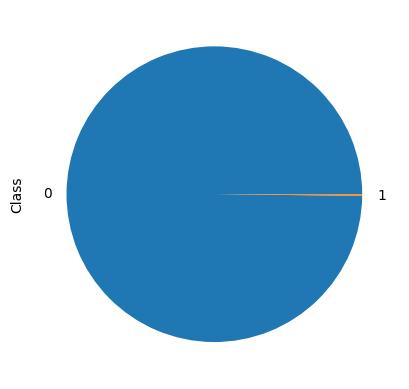

In [ ]:
#percentage of class distribution 
print((df.groupby('Class')['Class'].count()/df['Class'].count()) *100)
#pie chart representation
((df.groupby('Class')['Class'].count()/df['Class'].count()) *100).plot.pie()

In [ ]:
# Checking the correlation
corr = df.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


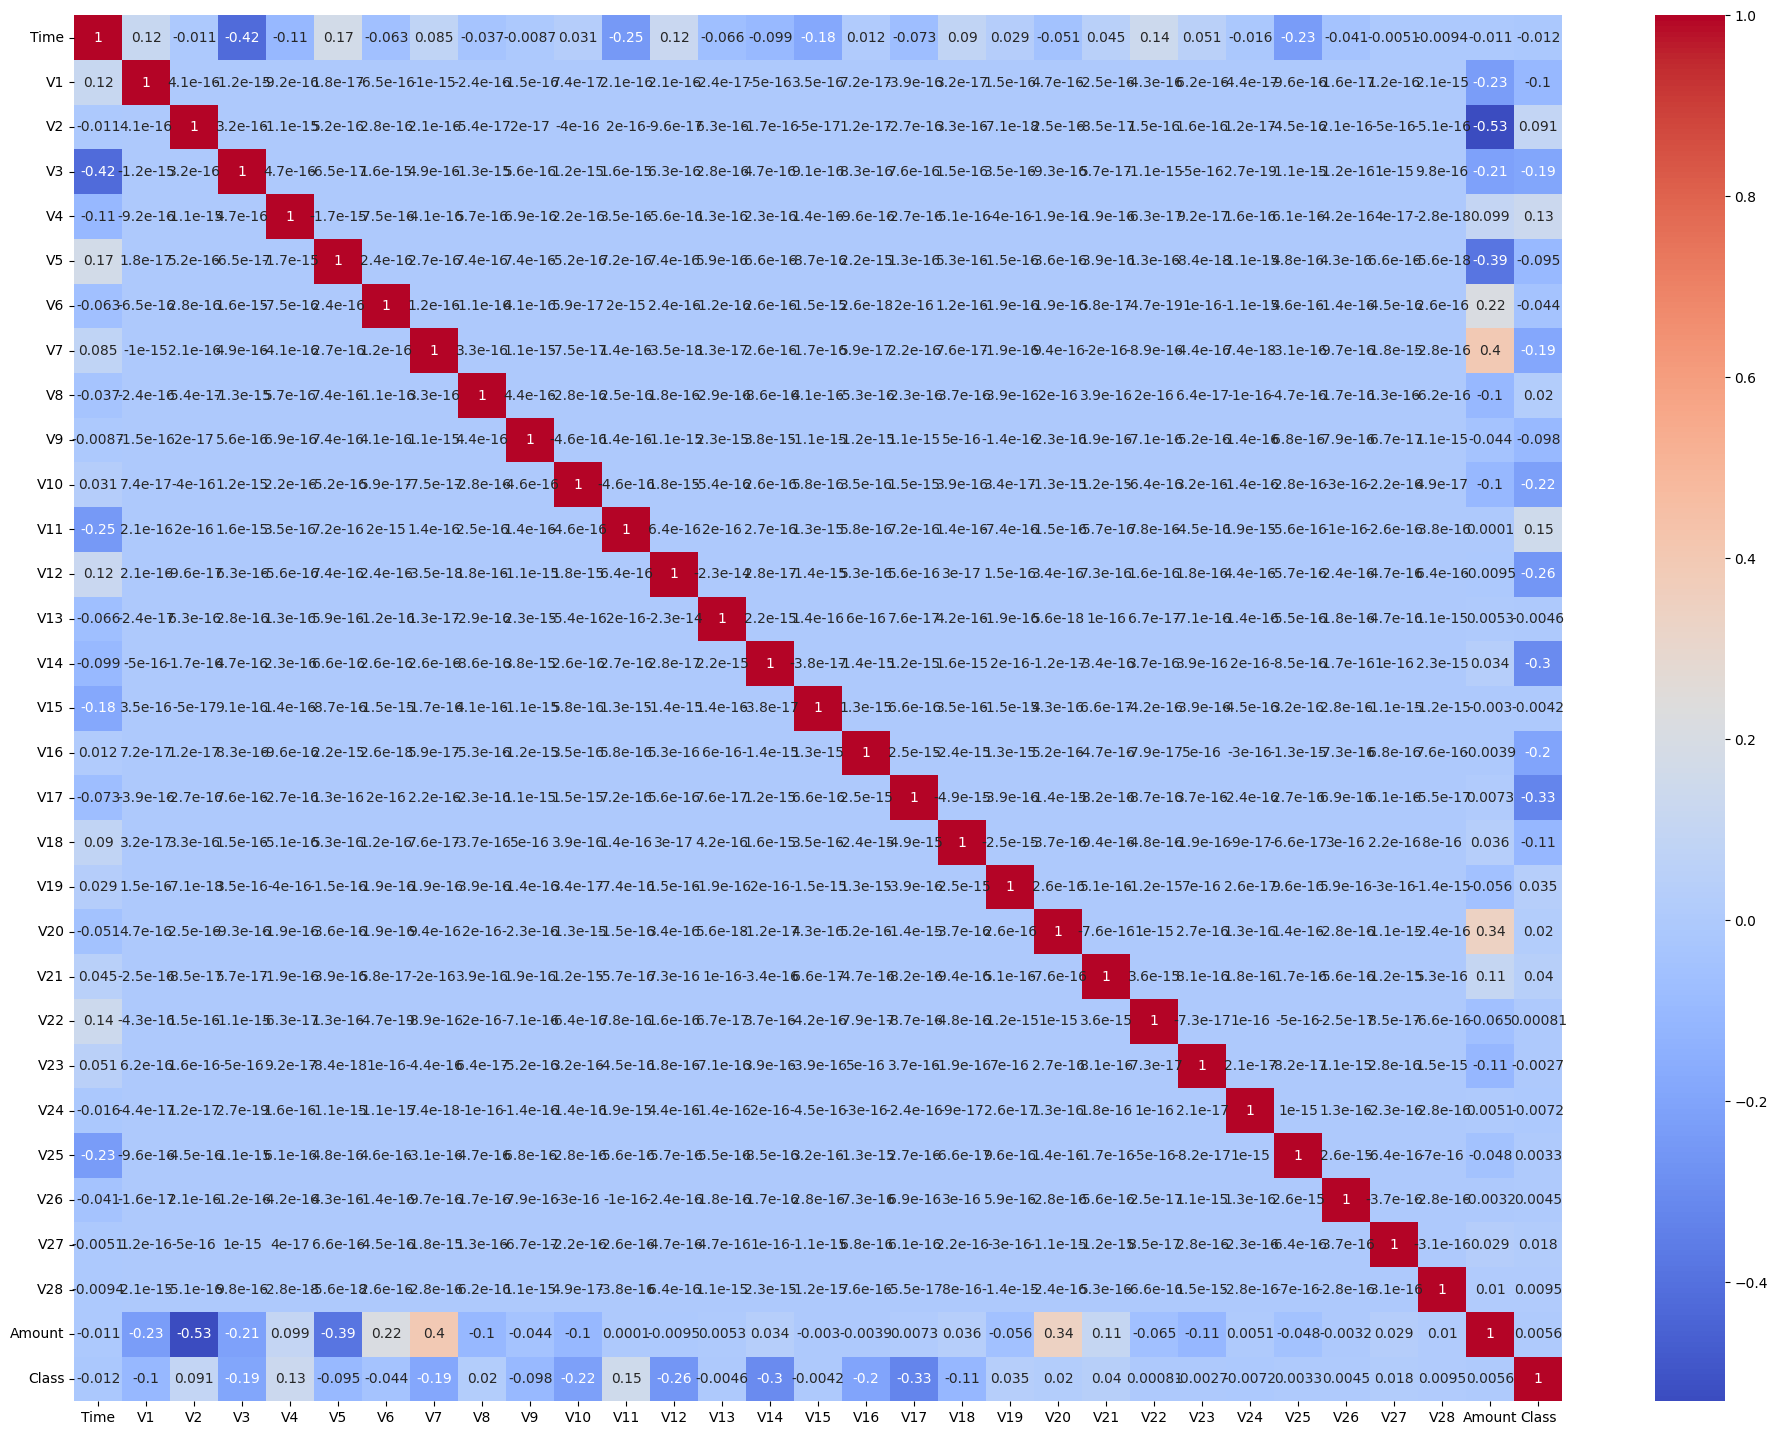

In [ ]:
# Checking the correlation in heatmap
plt.figure(figsize=(24,18))

sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.show()

In [ ]:
# As time is given in relative fashion, we are using pandas.Timedelta
# It Represents a duration, the difference between two times or dates.
Delta_Time = pd.to_timedelta(df['Time'], unit='s')
#Create derived columns hours
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)


In [ ]:
# Droping unnecessary columns
# We will drop Time,as we have derived the Hour from the time column 
df.drop('Time', axis = 1, inplace= True)

#  Train Test Split

In [ ]:
# Splitting the dataset into X and y
y= df['Class']
X = df.drop(['Class'], axis=1)

In [ ]:
#first five rows of X
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#first five rows of y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [ ]:
#splitting the dataset with train test split
# Splitting the dataset using train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.20)

In [ ]:
# Checking the spread of data post split
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
396
96


In [ ]:
# Accumulating all the column names under one variable
cols = list(X.columns.values)

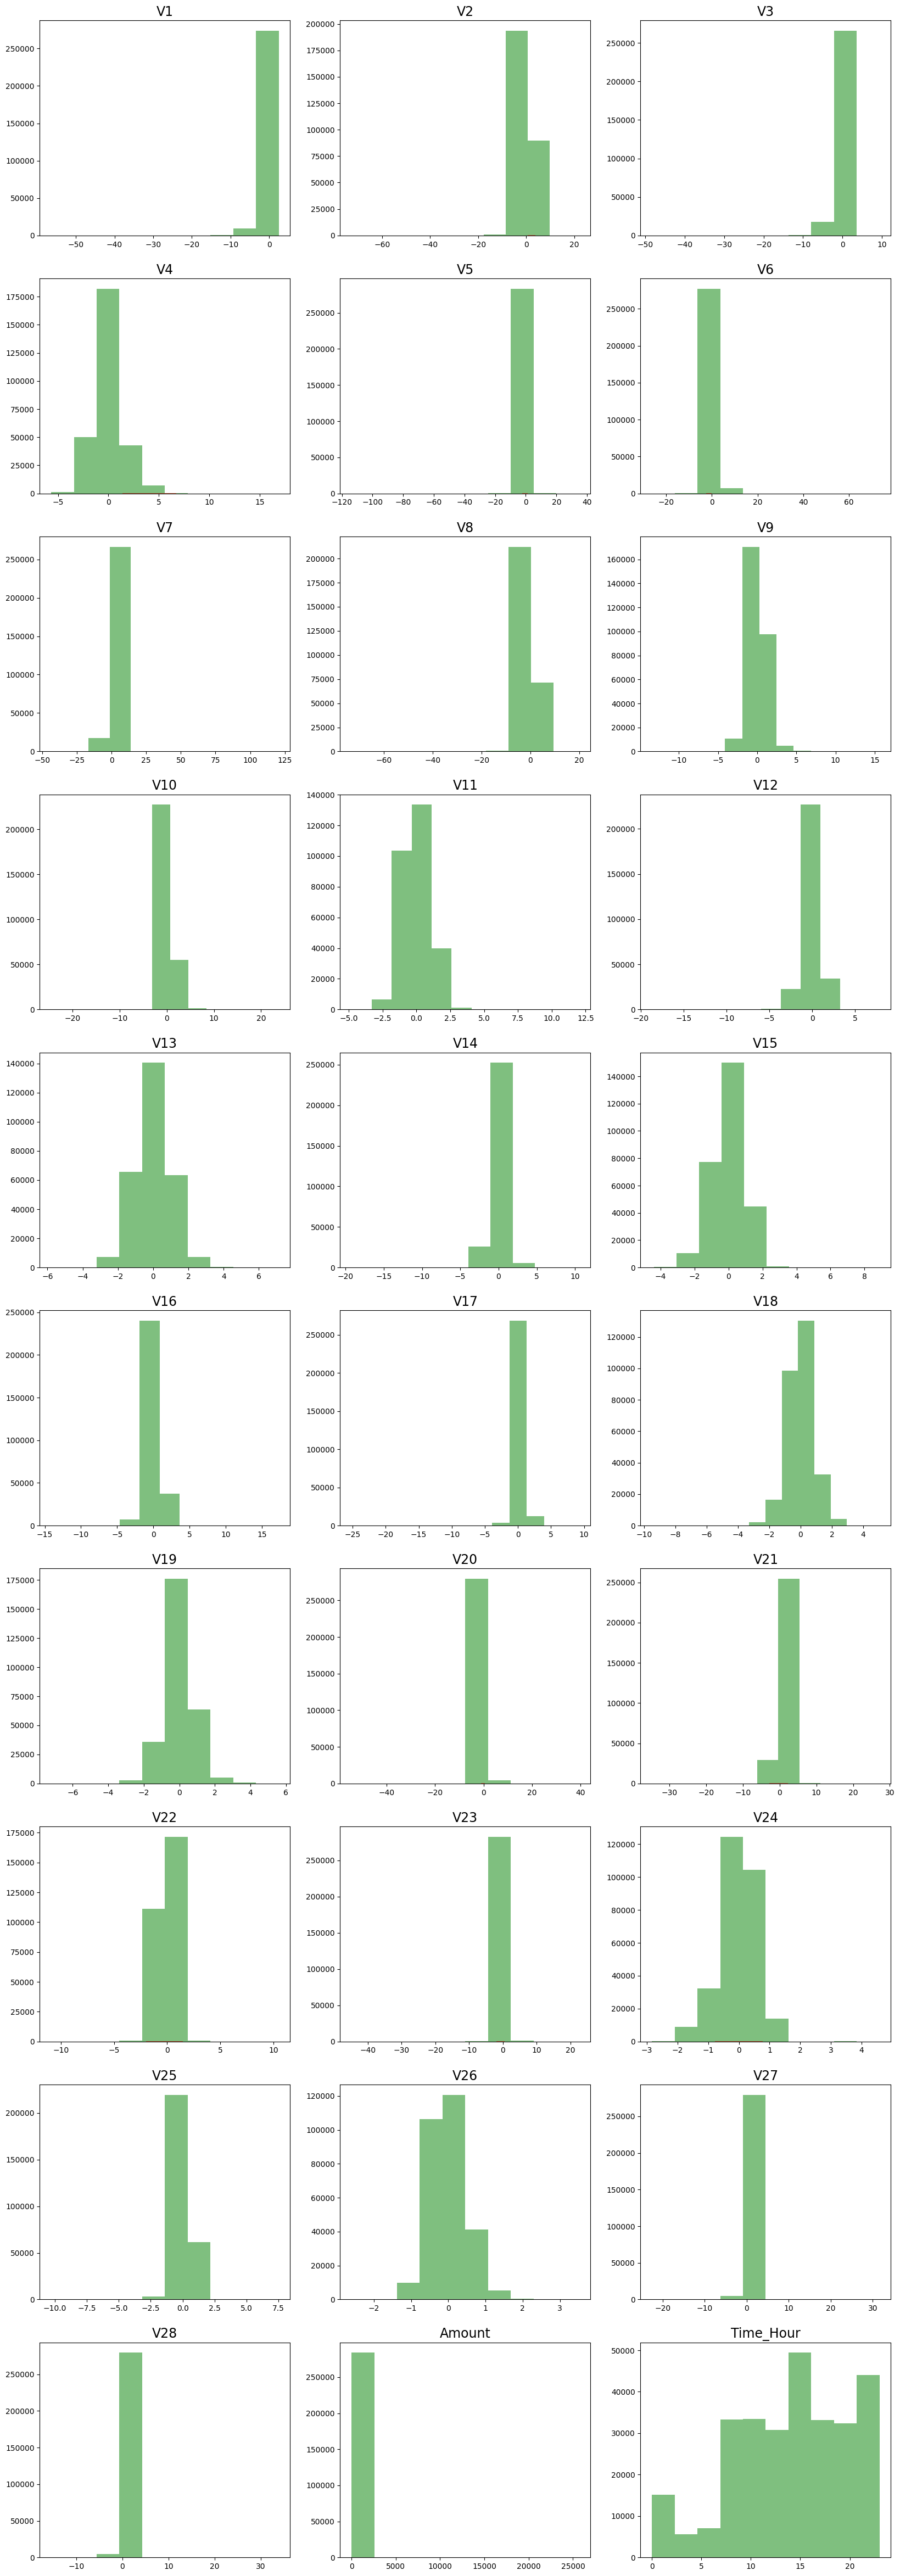

In [ ]:
# plot the histogram of a variable from the dataset to see the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
    plt.subplot(10,3,n+1)
    plt.hist(X[col][normal_records], color='green', alpha=0.5)
    plt.hist(X[col][fraud_records], color='red', alpha=0.5)
    plt.title(col, fontsize=17)
plt.show()

# Model Building

In [ ]:
#Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Methodology','Model','Accuracy','roc_value','threshold'])

In [ ]:
# Created a common function to plot confusion matrix
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

## Logistic regression

In [ ]:
# # Created a common function to fit and predict on a Logistic Regression model for both L1 and L2
def buildAndRunLogisticModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):

  # Logistic Regression
  from sklearn import linear_model
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )

  searchCV_l1.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_)

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_)  


  #find predicted vallues
  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
    
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'roc_value': l2_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'roc_value': l1_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)
  return df_Results

## K-Nearest Neighbors

In [ ]:
# Created a common function to fit and predict on a KNN model
def buildAndRunKNNModels(df_Results,Methodology, X_train,y_train, X_test, y_test ):

  #create KNN model and fit the model with train dataset
  knn = KNeighborsClassifier(n_neighbors = 5,n_jobs=16)
  knn.fit(X_train,y_train)
  score = knn.score(X_test,y_test)
  print("model score")
  print(score)
  
  #Accuracy
  y_pred = knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))


  knn_probs = knn.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print("KNN roc_value: {0}" .format(knn_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("KNN threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'KNN','Accuracy': score,'roc_value': knn_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results


## Random Forest

In [ ]:
# Created a common function to fit and predict on a Random Forest model
def buildAndRunRandomForestModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):
  #Evaluate Random Forest model

  # Create the model with 100 trees
  RF_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', random_state=42)
  # Fit on training data
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('Model Accuracy: {0}'.format(RF_test_score))


  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, rf_predictions)
  print("classification Report")
  print(classification_report(y_test, rf_predictions))

  # Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print("Random Forest roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Random Forest','Accuracy': RF_test_score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results


## XGBoost 

In [ ]:
# Created a common function to fit and predict on a XGBoost model
def buildAndRunXGBoostModels(df_Results, Methodology,X_train,y_train, X_test, y_test ):
  #Evaluate XGboost model
  XGBmodel = XGBClassifier(random_state=42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))
  # Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print("XGboost roc_value: {0}" .format(XGB_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGBoost threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results


## Support Vector Machines 

In [ ]:
def buildAndRunSVMModels(df_Results, Methodology, X_train,y_train, X_test, y_test ):
 
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import roc_auc_score

  clf = SVC(kernel='sigmoid', random_state=42)
  clf.fit(X_train,y_train)
  y_pred_SVM = clf.predict(X_test)
  SVM_Score = accuracy_score(y_test,y_pred_SVM)
  print("accuracy_score : {0}".format(SVM_Score))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_SVM)
  print("classification Report")
  print(classification_report(y_test, y_pred_SVM))

  # Run classifier
  classifier = SVC(kernel='sigmoid' , probability=True)
  svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, svm_probs)
  
  print("SVM roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, svm_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("SVM threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'SVM','Accuracy': SVM_Score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

# Performing cross validation with RepeatedKFold

In [ ]:
#Lets perfrom RepeatedKFold and check the results
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     5      9     13 ... 284798 284800 284803]
TRAIN: [     0      2      3 ... 284803 284805 284806] TEST: [     1      6     11 ... 284788 284799 284804]
TRAIN: [     0      1      2 ... 284803 284804 284805] TEST: [     4     22     23 ... 284801 284802 284806]
TRAIN: [     0      1      2 ... 284803 284804 284806] TEST: [     3      7     12 ... 284791 284792 284805]
TRAIN: [     1      3      4 ... 284804 284805 284806] TEST: [     0      2      8 ... 284776 284786 284797]
TRAIN: [     0      1      3 ... 284802 284804 284806] TEST: [     2      4      5 ... 284800 284803 284805]
TRAIN: [     0      1      2 ... 284803 284805 284806] TEST: [    16     18     22 ... 284785 284786 284804]
TRAIN: [     1      2      3 ... 284804 284805 284806] TEST: [     0      8     15 ... 284793 284799 284801]
TRAIN: [     0      2      4 ... 284803 284804 284805] TEST: [     1      3     14 ... 284791 284792 284806]
TRAIN: [     0     

## Logistic Regression with L1 And L2 Regularisation

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.9737350956591557
Max auc_roc for l2: 0.9834006207835829
Parameters for l1 regularisations
[[-0.05543553 -0.12669497 -0.18044361  0.06590485 -0.261113    0.09481019
   0.11722342 -0.03149177 -0.14273    -0.14206701 -0.03325529  0.01001918
  -0.13865289 -0.22141423  0.01179079 -0.11242233 -0.21651293  0.03455518
   0.00689093  0.24086307  0.0933668  -0.02747516  0.00772779 -0.00960572
  -0.02459     0.00806775 -0.06944631  0.00623729 -0.00648687 -0.11657488]]
[-2.10036288]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.52344301,
        0.59914976, 0.64519937, 0.99266688, 0.99573626, 0.99259152,
        0.98941162, 0.9875416 , 0.98906625, 0.99084333, 0.99018022,
        0.99236295, 0.99029451, 0.99060597, 0.99642072, 0.9938989 ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.53110167,
        0.46504925, 0.45642402, 0.89466362, 0.92159688, 0.93069458,
        0.91241952, 0.9202509 , 0.95444

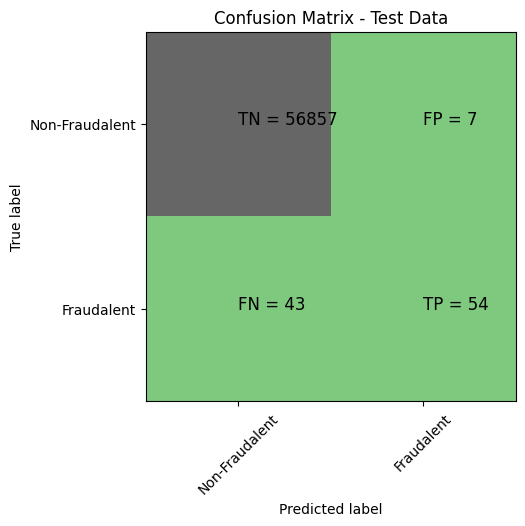

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.56      0.68        97

    accuracy                           1.00     56961
   macro avg       0.94      0.78      0.84     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9991397622934991
Confusion Matrix


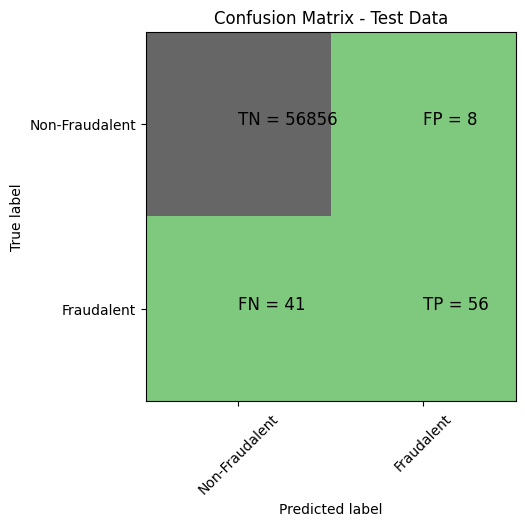

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.58      0.70        97

    accuracy                           1.00     56961
   macro avg       0.94      0.79      0.85     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9824700207113808
l2 threshold: 0.0021045726192611245
ROC for the test dataset 98.2%


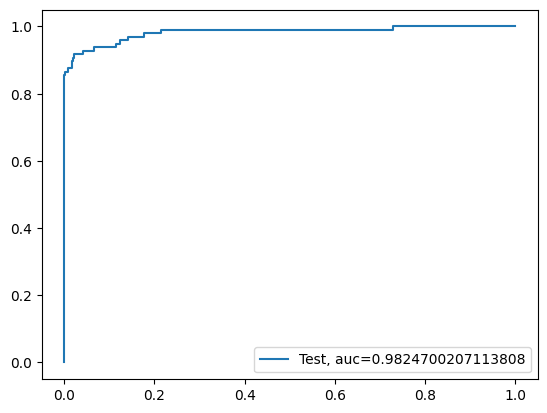

l1 roc_value: 0.8740338677488412
l1 threshold: 0.0520573084198151
ROC for the test dataset 87.4%


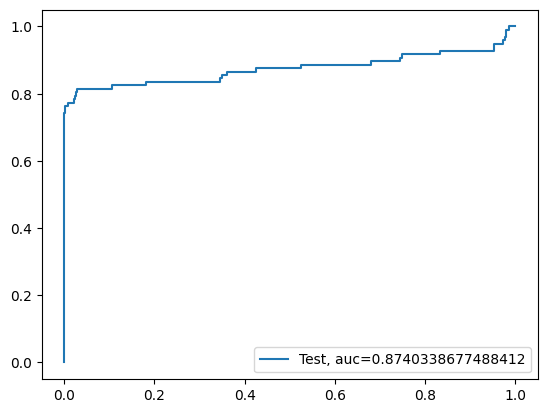

Time Taken by Model: --- 300.69112253189087 seconds ---
------------------------------------------------------------


In [ ]:
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"RepeatedKFold Cross Validation", X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )


## KNN Model

KNN Model
model score
0.9992450975228665
Confusion Matrix


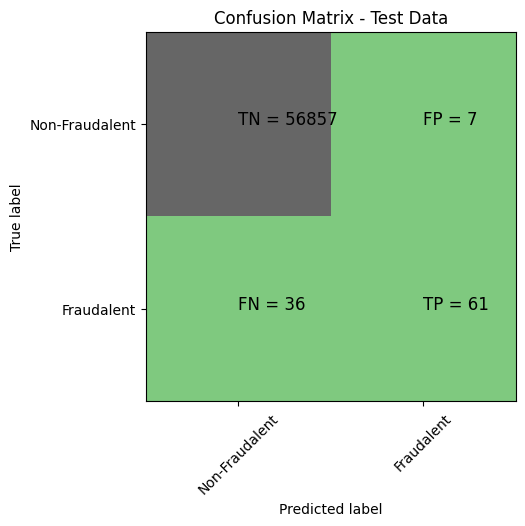

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.63      0.74        97

    accuracy                           1.00     56961
   macro avg       0.95      0.81      0.87     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8554765684374801
KNN threshold: 0.2
ROC for the test dataset 85.5%


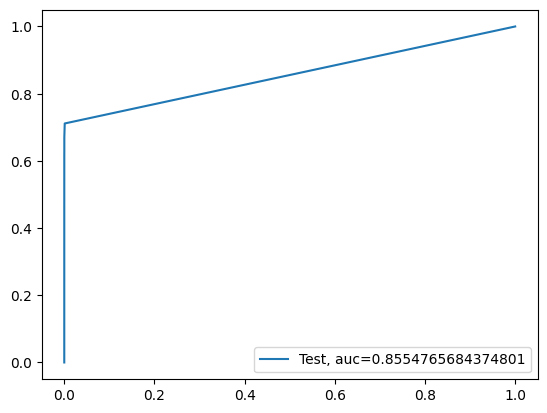

Time Taken by Model: --- 225.52559208869934 seconds ---
------------------------------------------------------------


In [ ]:
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## Random Forest Model



Random Forest Model
Model Accuracy: 0.9996313266972139
Confusion Matrix


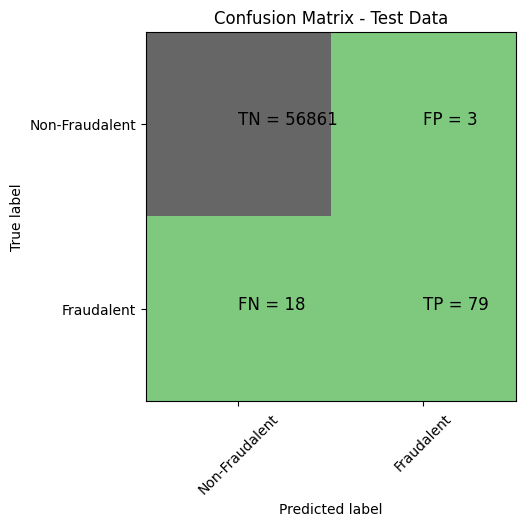

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.81      0.88        97

    accuracy                           1.00     56961
   macro avg       0.98      0.91      0.94     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9469763088200315
Random Forest threshold: 0.02
ROC for the test dataset 94.7%


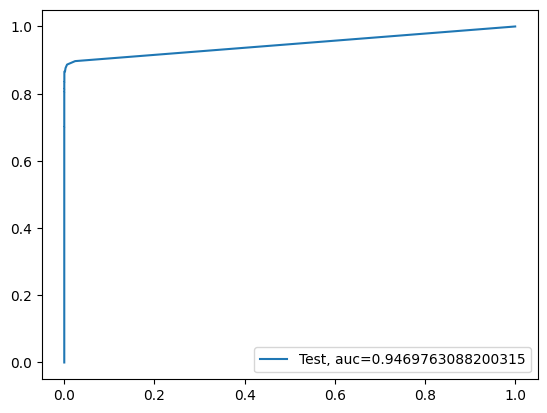

Time Taken by Model: --- 216.77394604682922 seconds ---
------------------------------------------------------------


In [ ]:
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## XGBoost Model

XGBoost Model
Model Accuracy: 0.9997191060550201
Confusion Matrix


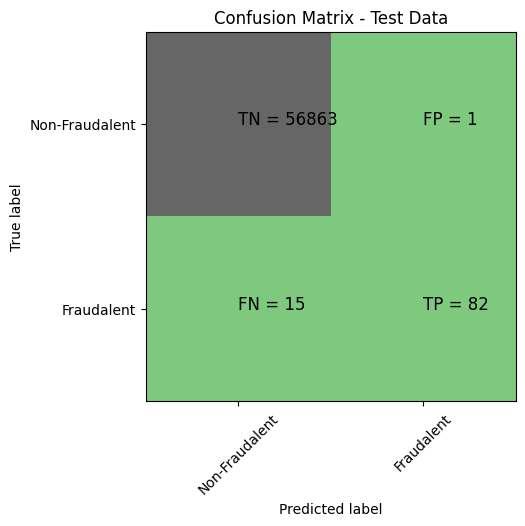

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.85      0.91        97

    accuracy                           1.00     56961
   macro avg       0.99      0.92      0.96     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9749819065493215
XGBoost threshold: 0.00034580560168251395
ROC for the test dataset 97.5%


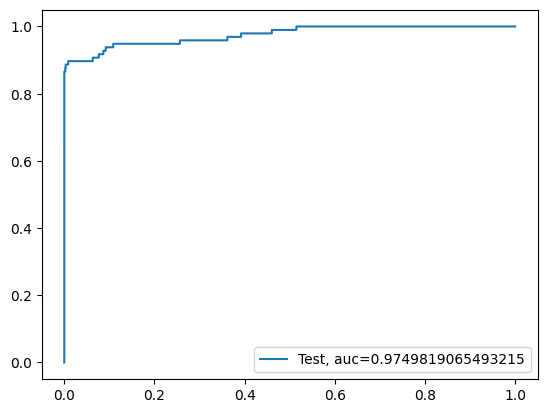

Time Taken by Model: --- 112.31034016609192 seconds ---
------------------------------------------------------------


In [ ]:
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## SVM Model

SVM Model with Sigmoid Kernel
accuracy_score : 0.9974895103667422
Confusion Matrix


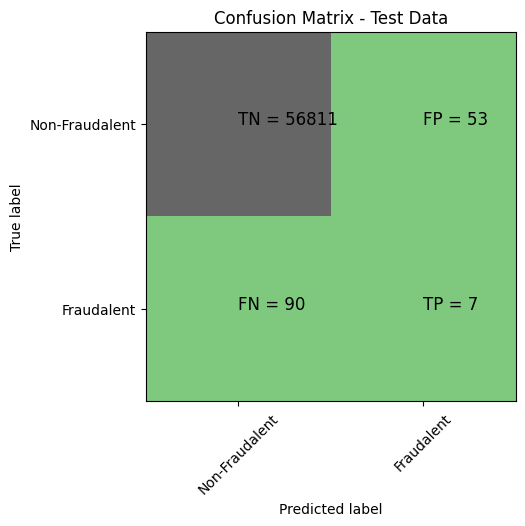

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.12      0.07      0.09        97

    accuracy                           1.00     56961
   macro avg       0.56      0.54      0.54     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.7133116308616979
SVM threshold: 0.0036170290417494276
ROC for the test dataset 71.3%


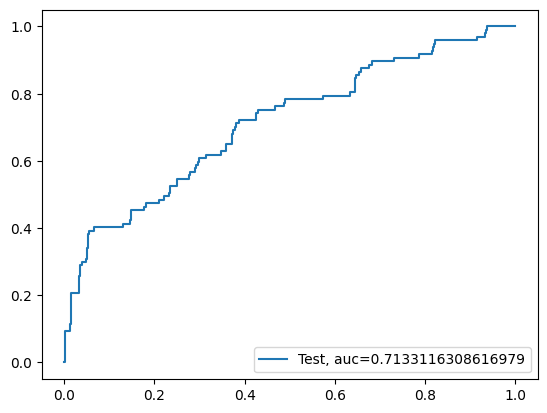

Time Taken by Model: --- 173.1343433856964 seconds ---


In [ ]:
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999122,0.982470,0.002105
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999140,0.874034,0.052057
2,RepeatedKFold Cross Validation,KNN,0.999245,0.855477,0.200000
3,RepeatedKFold Cross Validation,Random Forest,0.999631,0.946976,0.020000
4,RepeatedKFold Cross Validation,XGBoost,0.999719,0.974982,0.000346
5,RepeatedKFold Cross Validation,SVM,0.997490,0.713312,0.003617


## Results for cross validation with RepeatedKFold:

Looking at Accuracy and ROC value we have "Logistic Regression with L2 Regularisation" which has provided best results for cross validation with RepeatedKFold technique

But in a fraud detection problem where false negatives (failing to detect fraud) may be more costly than false positives (flagging a legitimate transaction as fraudulent), you may want to prioritize recall over precision.

considering this we have the "XGBoost Model" with the highest recall.

# Perform CrossValidation with StratifiedKFold

In [ ]:
#Lets perfrom StratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


## Logistic Regression with L1 And L2 Regularisation

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.9652106893977332
Max auc_roc for l2: 0.9824998302436573
Parameters for l1 regularisations
[[-0.03660539 -0.1358827  -0.20474594  0.04333662 -0.24034598  0.08416903
   0.12654905 -0.04815306 -0.14258132 -0.1384162  -0.11668372  0.05505155
  -0.15637116 -0.24216184 -0.03137093 -0.09904364 -0.23133976  0.05582481
   0.02122044  0.20503748  0.09013502  0.00148754 -0.03796378 -0.00392139
  -0.14797782 -0.00701001 -0.06594801 -0.00660368 -0.00656465 -0.12981985]]
[-2.0409044]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.48341269,
        0.44979055, 0.48500892, 0.78098262, 0.9497821 , 0.94525947,
        0.91827811, 0.91446679, 0.94989144, 0.94933682, 0.94178407,
        0.94900653, 0.92481293, 0.94421561, 0.9164553 , 0.97793244],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.54612019,
        0.57709187, 0.60597219, 0.84651057, 0.93343227, 0.93465714,
        0.92629828, 0.92557122, 0.944815

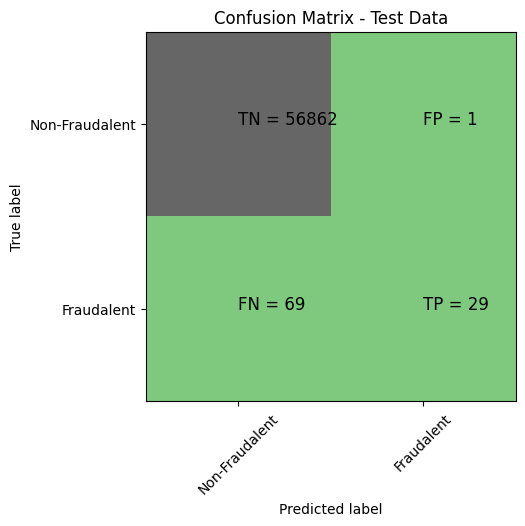

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


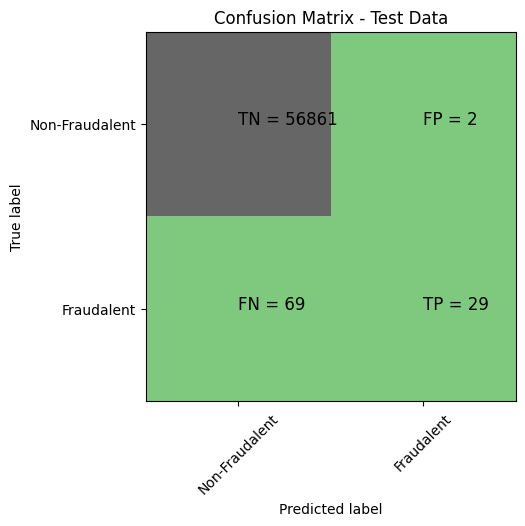

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833866719401124
l2 threshold: 0.0015540600590433185
ROC for the test dataset 98.3%


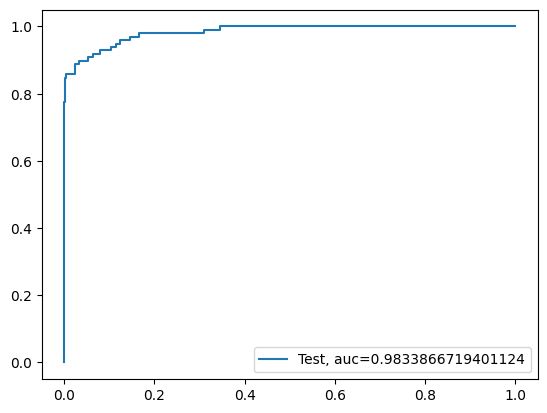

l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766199863
ROC for the test dataset 88.9%


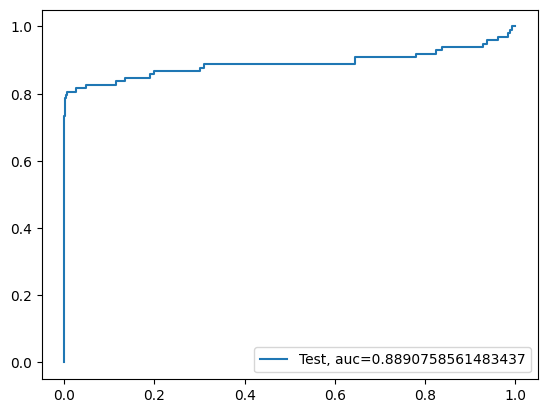

Time Taken by Model: --- 295.1625201702118 seconds ---
------------------------------------------------------------


In [ ]:
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"StratifiedKFold Cross Validation", X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )


## KNN Model

KNN Model
model score
0.9991924299081828
Confusion Matrix


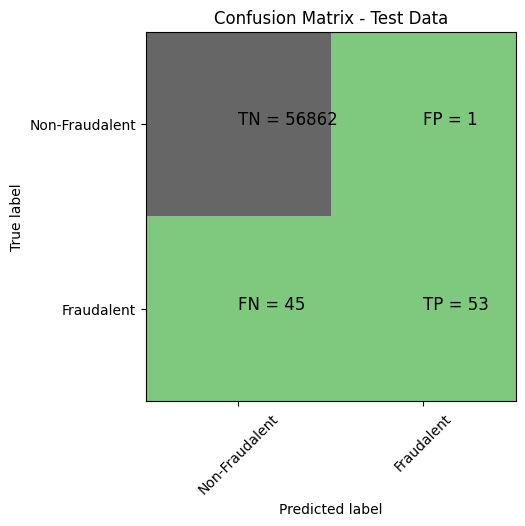

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8057457828285457
KNN threshold: 0.2
ROC for the test dataset 80.6%


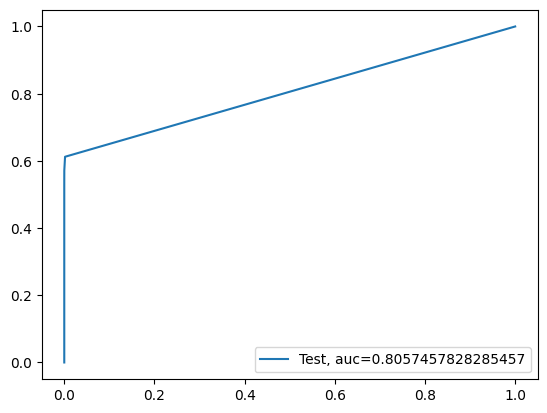

Time Taken by Model: --- 225.87949681282043 seconds ---
------------------------------------------------------------


In [ ]:
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## Random Forest Model

Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


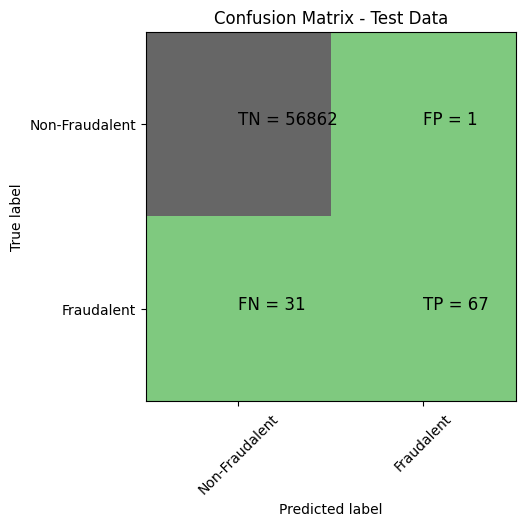

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


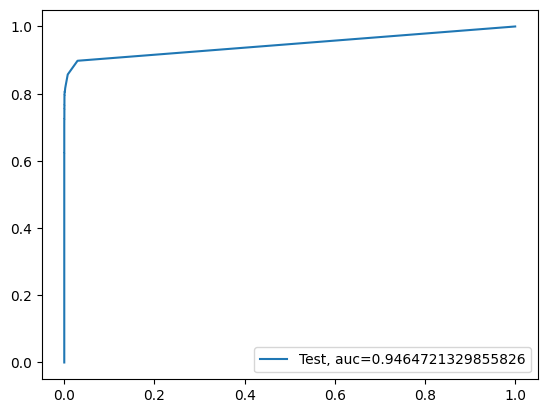

Time Taken by Model: --- 195.38756918907166 seconds ---
------------------------------------------------------------


In [ ]:
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## XGBoost Model

XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


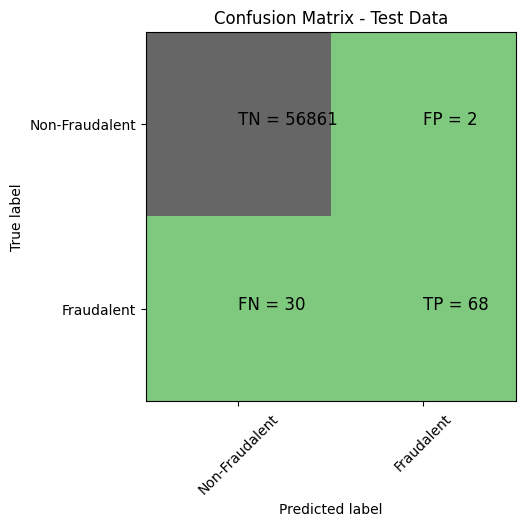

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.69      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.85      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9728125638170081
XGBoost threshold: 0.00010038274194812402
ROC for the test dataset 97.3%


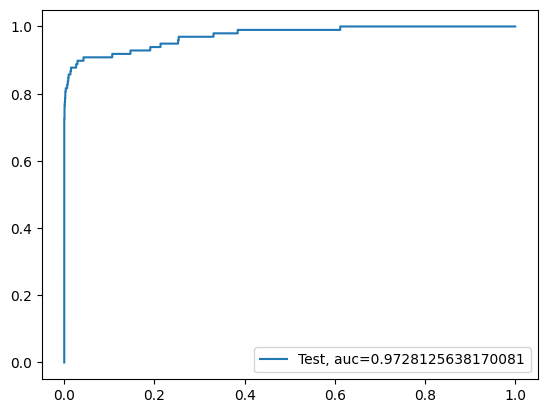

Time Taken by Model: --- 109.68916416168213 seconds ---
------------------------------------------------------------


In [ ]:
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## SVM Model

SVM Model
accuracy_score : 0.9982795245869981
Confusion Matrix


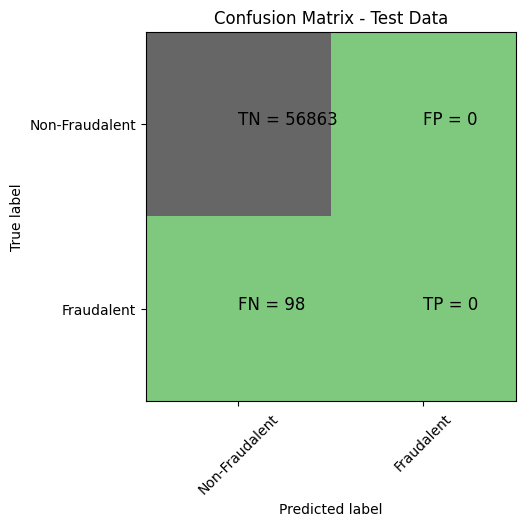

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.40177034885494567
SVM threshold: 0.0043433548005676155
ROC for the test dataset 40.2%


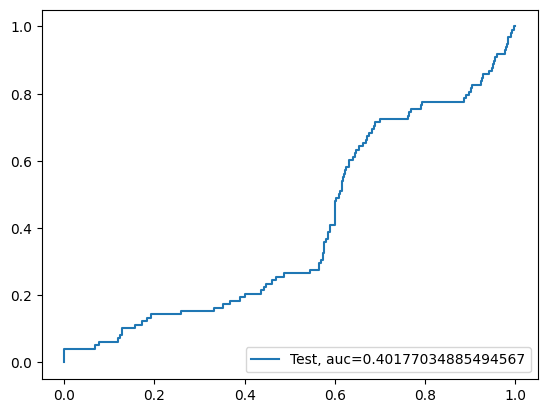

Time Taken by Model: --- 185.76600003242493 seconds ---


In [ ]:
print("SVM Model")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Checking the df_result dataframe which contains consolidated results of all the runs
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999122,0.982470,0.002105
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999140,0.874034,0.052057
2,RepeatedKFold Cross Validation,KNN,0.999245,0.855477,0.200000
3,RepeatedKFold Cross Validation,Random Forest,0.999631,0.946976,0.020000
4,RepeatedKFold Cross Validation,XGBoost,0.999719,0.974982,0.000346
5,RepeatedKFold Cross Validation,SVM,0.997490,0.713312,0.003617
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983387,0.001554
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,KNN,0.999192,0.805746,0.200000
9,StratifiedKFold Cross Validation,Random Forest,0.999438,0.946472,0.010000


## Results for Cross Validation with StratifiedKFold

 As the results show Logistic Regression with L2 Regularisation for StratifiedKFold cross validation provided best results in case of roc value.

# Applying the best hyperparameter on the model 

In [ ]:
# Logistic Regression
from sklearn import linear_model #import the package
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

clf.fit(X_train_SKF_cv, y_train_SKF_cv)
print ('Max auc_roc for l2:', clf.scores_[1].mean(axis=0).max())


#find predicted vallues
y_pred_l2 = clf.predict(X_test)


#Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)


print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))


from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print("l2 roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold))

Max auc_roc for l2: 0.9824998302436573
Accuarcy of Logistic model with l2 regularisation : 0.9987886661282961
l2 roc_value: 0.9754882457590359
l2 threshold: 0.0016079447209384513


In [ ]:
# Creating a dataframe with the coefficient values
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Feature','Importance Coefficient']

In [ ]:
coefficients

,Feature,Importance Coefficient
0,V1,0.006833
1,V2,0.061459
2,V3,-0.067031
3,V4,0.218370
4,V5,0.054004
5,V6,-0.031960
6,V7,-0.022803
7,V8,-0.114960
8,V9,-0.069541
9,V10,-0.163664


# Model Building with balancing Classes
# Using Random Over Sampling

In [ ]:
# Creating the dataset with RandomOverSampler and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over= ROS.fit_resample(X_train, y_train)
  
X_over = pd.DataFrame(data=X_over, columns=cols)

## Logistic Regression with L1 And L2 Regularisation

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.986420759813479
Parameters for l1 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

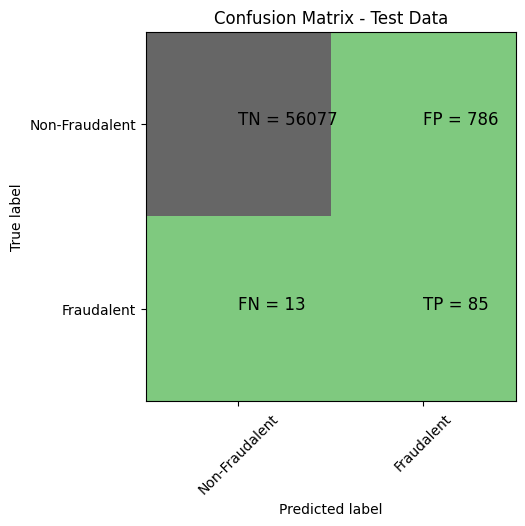

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


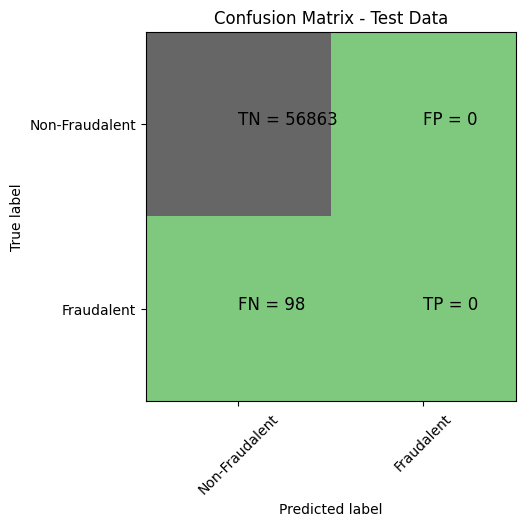

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.980601244595406
l2 threshold: 0.42585965020958605
ROC for the test dataset 98.1%


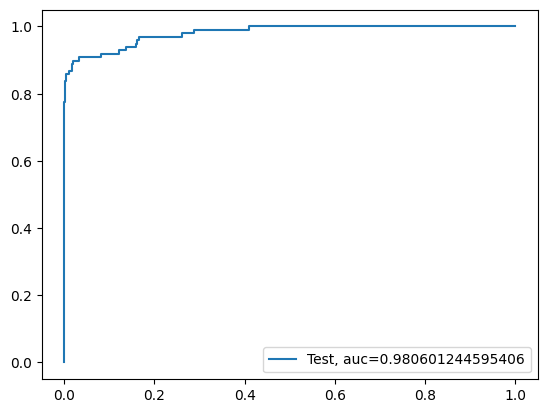

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


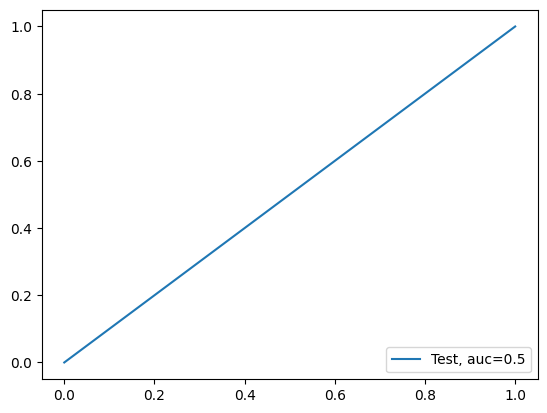

Time Taken by Model: --- 410.6423707008362 seconds ---
------------------------------------------------------------


In [ ]:
Data_Imbalance_Handiling	 = "Random Oversampling with StratifiedKFold CV "
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results , Data_Imbalance_Handiling , X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*60 )

## KNN Model

KNN Model
model score
0.9980688541282632
Confusion Matrix


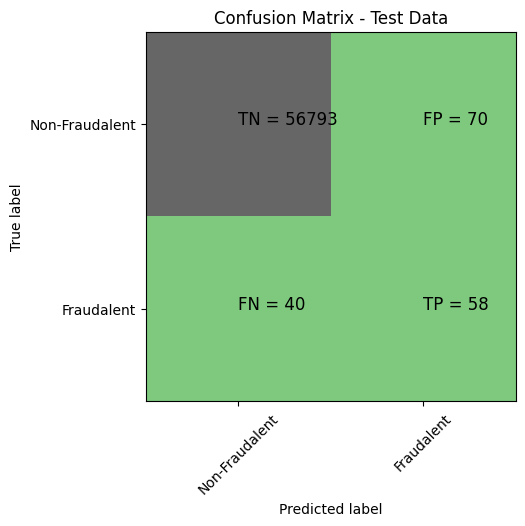

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.805604465728046
KNN threshold: 0.2
ROC for the test dataset 80.6%


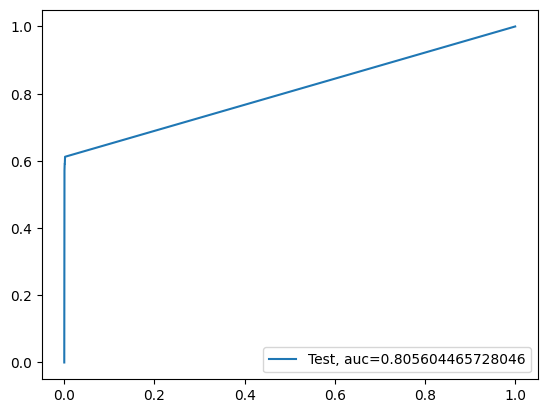

In [ ]:
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)


## Random Forest Model

Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


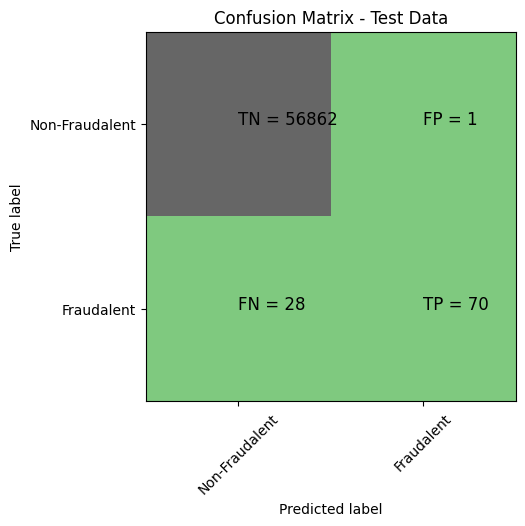

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.71      0.83        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.91     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.945895110589828
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


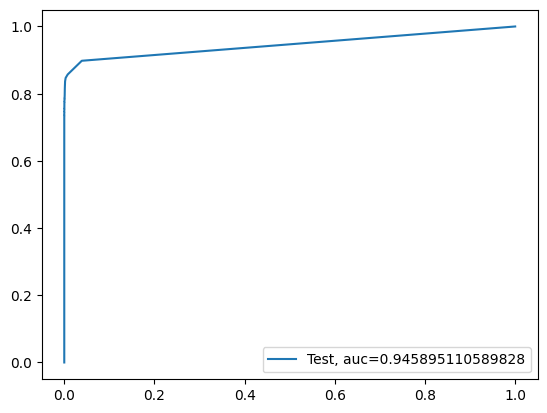

In [ ]:
print("Random Forest Model")
df_Results = buildAndRunRandomForestModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)

## XGBoost model

XGBoost Model
Model Accuracy: 0.9994733238531627
Confusion Matrix


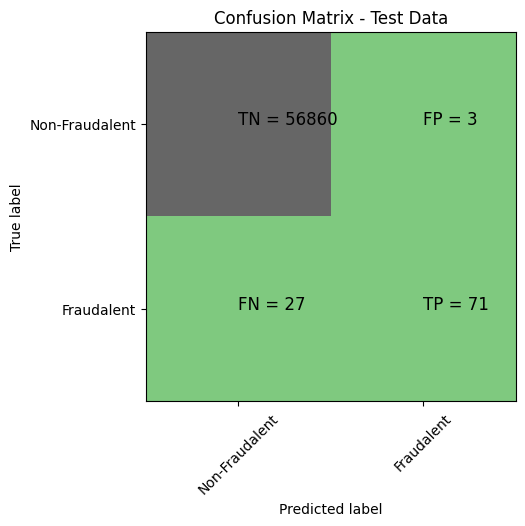

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.72      0.83        98

    accuracy                           1.00     56961
   macro avg       0.98      0.86      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9824138719378155
XGBoost threshold: 0.00020656993729062378
ROC for the test dataset 98.2%


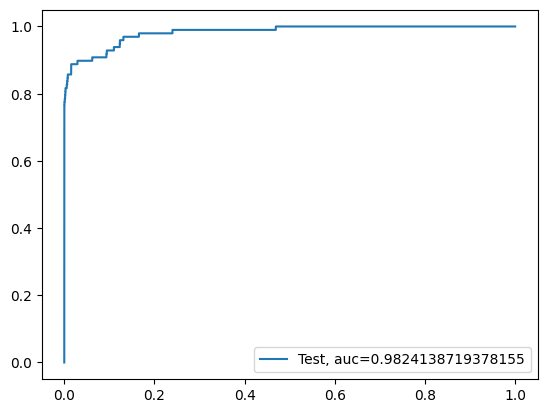

In [ ]:
print("XGBoost Model")

df_Results = buildAndRunXGBoostModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)


# Oversampling with SMOTE Oversampling


In [ ]:
# Creating dataframe with Smote and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train)
  
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

## Logistic Regression with L1 And L2 Regularisation

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9930151908600335
Parameters for l1 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

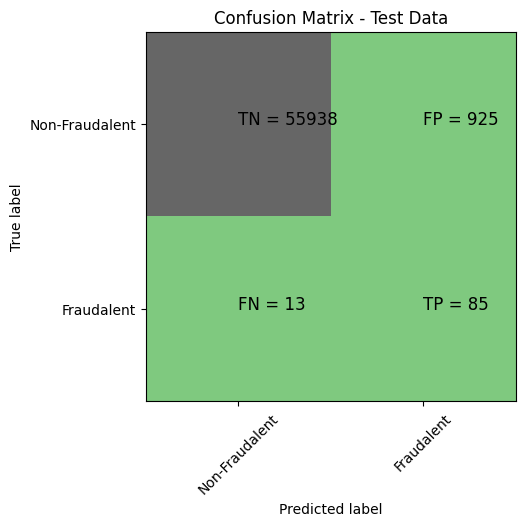

classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


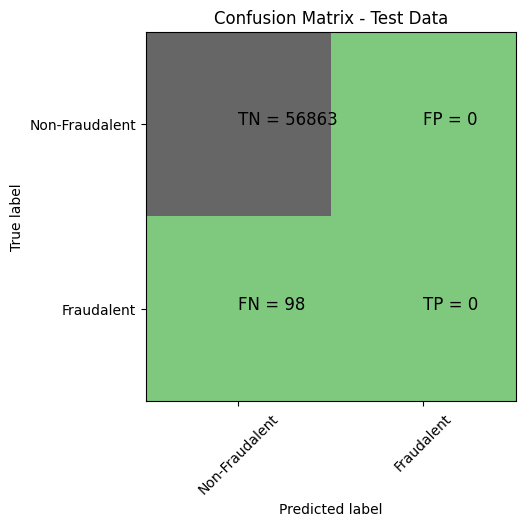

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9745828408918391
l2 threshold: 0.3939516300872773
ROC for the test dataset 97.5%


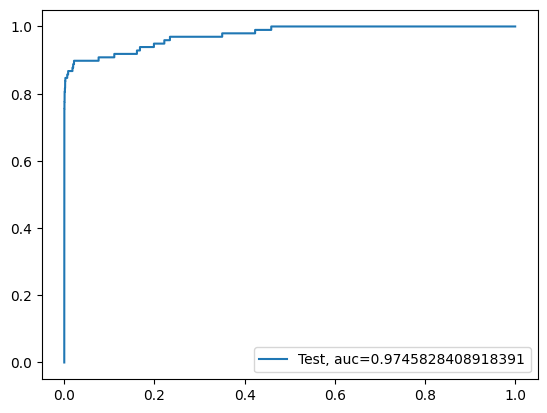

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


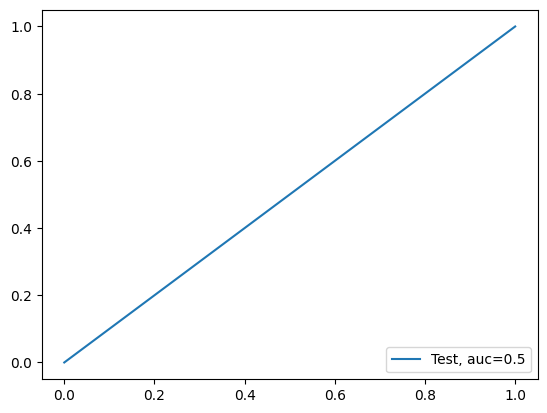

In [ ]:
Data_Imbalance_Handiling	 = "SMOTE Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")

df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)


## KNN Model

KNN Model
model score
0.9946805709169432
Confusion Matrix


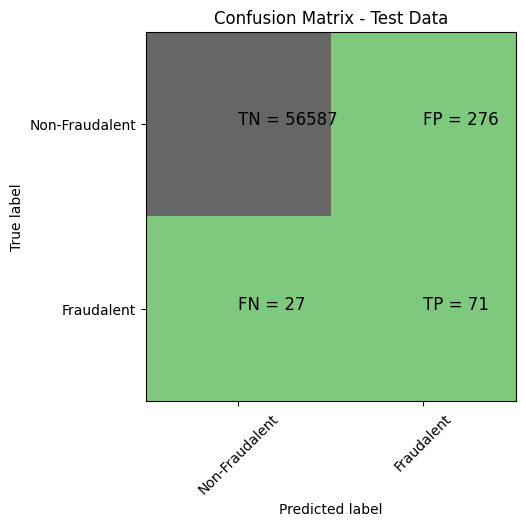

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.20      0.72      0.32        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.66     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8602674455287628
KNN threshold: 0.6
ROC for the test dataset 86.0%


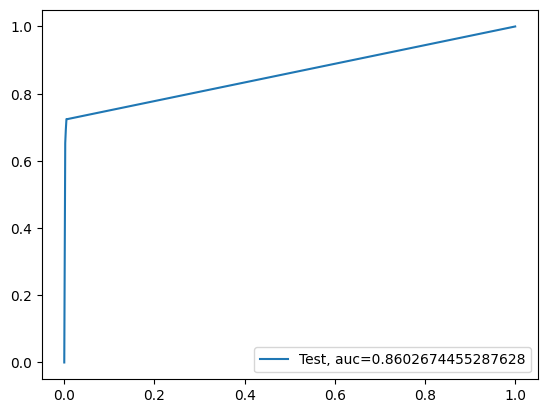

In [ ]:
print("KNN Model")

df_Results = buildAndRunKNNModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)


## Random Forest Model

Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


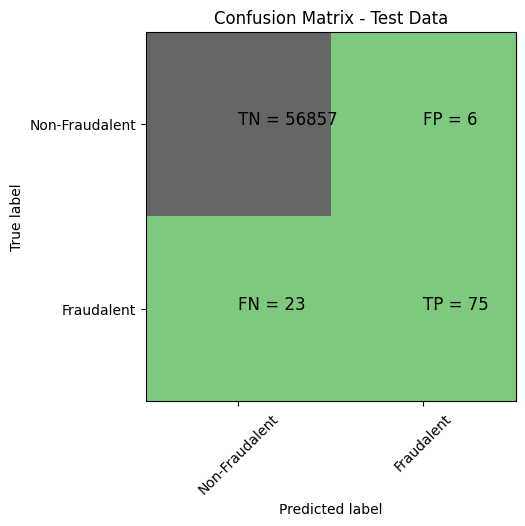

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset 96.1%


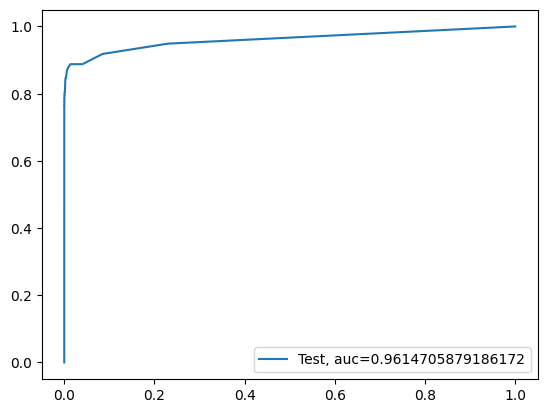

In [ ]:
print("Random Forest Model")

df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)




## XGBoost



XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


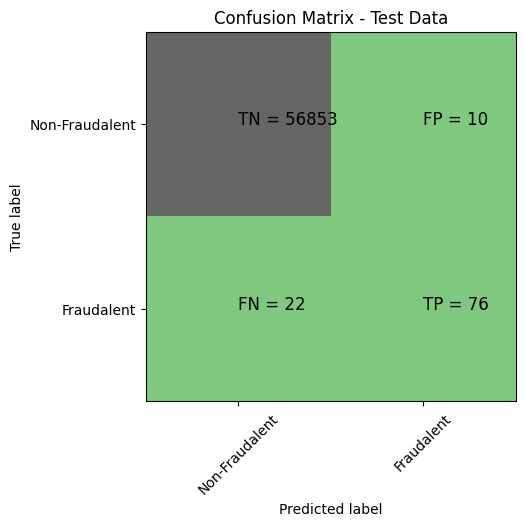

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.974152698555461
XGBoost threshold: 0.00022058551257941872
ROC for the test dataset 97.4%


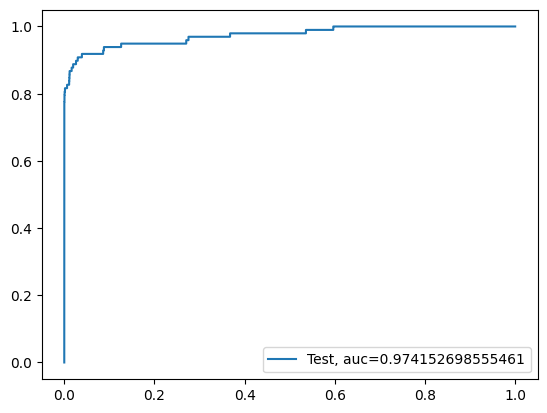

In [ ]:
print("XGBoost Model")

df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)

In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999122,0.982470,0.002105
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999140,0.874034,0.052057
2,RepeatedKFold Cross Validation,KNN,0.999245,0.855477,0.200000
3,RepeatedKFold Cross Validation,Random Forest,0.999631,0.946976,0.020000
4,RepeatedKFold Cross Validation,XGBoost,0.999719,0.974982,0.000346
5,RepeatedKFold Cross Validation,SVM,0.997490,0.713312,0.003617
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983387,0.001554
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,KNN,0.999192,0.805746,0.200000
9,StratifiedKFold Cross Validation,Random Forest,0.999438,0.946472,0.010000


# XGBoost Hyperparameter Tuning

In [ ]:
# Performing Hyperparameter tuning
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':range(60,130,150),
 'learning_rate':[0.05,0.1,0.125,0.15,0.2],
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(7,10)],
 'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch1 = RandomizedSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1,max_delta_step=0,
              missing=None, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, verbosity=1), 
              param_distributions = param_test, n_iter=5,scoring='roc_auc',n_jobs=-1, cv=5)

gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([153.98758874, 159.67195969, 159.27490959,  60.64672437,
          96.85120621]),
  'std_fit_time': array([ 1.89927467,  1.0551505 ,  2.0575047 ,  0.60438115, 13.88431099]),
  'mean_score_time': array([0.01662812, 0.01851239, 0.01706305, 0.01387653, 0.01337266]),
  'std_score_time': array([0.00413219, 0.00790479, 0.00801366, 0.00202325, 0.00316192]),
  'param_subsample': masked_array(data=[0.9, 0.9, 0.9, 0.8, 0.7],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[60, 60, 60, 60, 60],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[3, 1, 1, 1, 5],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[9, 9, 7, 3, 5],
               mask=[False, False, False

Model Accuracy: 0.9993328768806727
XGboost roc_value: 0.98260705017107
XGBoost threshold: 0.012225590646266937


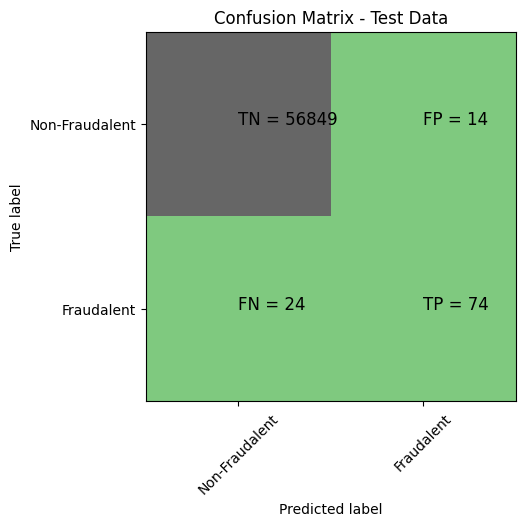

In [ ]:
# Creating XGBoost model with selected hyperparameters
from xgboost import XGBClassifier

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.125, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=1, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

# fit on the dataset
clf.fit(X_over, y_over ) 
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))
y_pred = clf.predict(X_test)
Plot_confusion_matrix(y_test,y_pred)


In [ ]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

XGboost roc_value: 0.98260705017107
XGBoost threshold: 0.012225590646266937
